In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, Cfrom sklearn import preprocessing, model_selectionSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing, model_selection
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from fastai.imports import *
import os
print(os.listdir("../input"))
from sklearn.metrics import accuracy_score
# Any results you write to the current directory are saved as output.
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

from fastai import *
from fastai.tabular import * 


#display results
import plotly
# import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

/kaggle/input/janatahack/train_8wry4cB.csv
/kaggle/input/janatahack/sample_submission_opxHi4g.csv
/kaggle/input/janatahack/test_Yix80N0.csv
['janatahack']


In [67]:
## to download csv file from the kernel
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

## display all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [96]:
train = pd.read_csv('../input/janatahack/train_8wry4cB.csv')
test = pd.read_csv('../input/janatahack/test_Yix80N0.csv')
submit = pd.read_csv('../input/janatahack/sample_submission_opxHi4g.csv')

In [97]:
display_all(train.head())

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


creating mapping for gender

In [98]:
map = {'male': 0, 'female': 1}
train = train.replace({"gender": map})
revmap =  {0: 'male', 1: 'female'}

In [99]:
## give label to data based on train/test and concat both data set
test['gender'] = 0
train['type'] = 'train'
test['type'] = 'test'
data = pd.concat([train, test], axis = 0, ignore_index= True) 

In [100]:
data.shape, test.shape, train.shape

((15000, 6), (4500, 6), (10500, 6))

In [101]:
display_all(data.isnull().sum())

session_id     0
startTime      0
endTime        0
ProductList    0
gender         0
type           0
dtype: int64

In [102]:
data.dtypes

session_id     object
startTime      object
endTime        object
ProductList    object
gender          int64
type           object
dtype: object

In [103]:
from datetime import datetime
data['startTime'] = data['startTime'].apply(lambda x: datetime.strptime(x, '%d/%m/%y %H:%M'))
data['endTime'] = data['endTime'].apply(lambda x: datetime.strptime(x, '%d/%m/%y %H:%M'))

In [104]:
data['diff_mins'] = (data['endTime'] - data['startTime']) / np.timedelta64(1,'m')

In [105]:
data.diff_mins.describe()

count    15000.000000
mean       130.356600
std       1880.782561
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      50752.000000
Name: diff_mins, dtype: float64

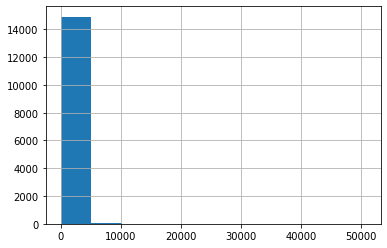

In [106]:
data.diff_mins.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd0f621898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fdd0f639cc0>]], dtype=object)

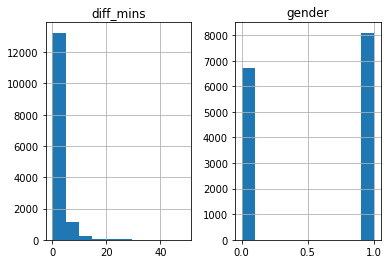

In [107]:
data[data['diff_mins']<50].hist()

In [108]:
data[data['diff_mins']>3000]

,session_id,startTime,endTime,ProductList,gender,type,diff_mins
55,u20930,2014-12-05 15:35:00,2014-12-09 10:38:00,A00002/B00001/C00010/D18354/;A00003/B00012/C00...,1,train,5463.0
62,u18364,2014-11-25 14:49:00,2014-12-01 11:35:00,A00002/B00004/C00102/D11613/;A00002/B00001/C00...,1,train,8446.0
64,u13611,2014-11-15 09:12:00,2014-11-18 14:16:00,A00003/B00021/C00055/D02305/;A00002/B00001/C00...,1,train,4624.0
70,u18738,2014-11-26 13:43:00,2014-12-13 02:03:00,A00001/B00027/C00224/D12693/;A00001/B00031/C00...,0,train,23780.0
256,u15001,2014-11-16 23:34:00,2014-12-16 04:35:00,A00002/B00001/C00059/D04809/;A00002/B00017/C00...,1,train,42061.0
...,...,...,...,...,...,...,...
14905,u16640,2014-11-21 12:31:00,2014-12-19 19:47:00,A00002/B00002/C00022/D08359/;A00003/B00022/C00...,0,test,40756.0
14914,u20156,2014-12-01 14:42:00,2014-12-12 10:51:00,A00002/B00002/C00007/D16808/;A00002/B00001/C00...,0,test,15609.0
14957,u16212,2014-11-18 23:58:00,2014-11-22 21:03:00,A00002/B00002/C00009/D06994/;A00002/B00002/C00...,0,test,5585.0
14966,u18551,2014-11-26 07:24:00,2014-12-14 23:12:00,A00002/B00002/C00002/D12230/;A00002/B00002/C00...,0,test,26868.0


In [109]:
data['startTimehour']  = data['startTime'].dt.hour.astype(int)
data['startTimemin']  = data['startTime'].dt.minute.astype(int)
data['endTimehour']  = data['endTime'].dt.hour.astype(float)
data['endTimemin']  = data['endTime'].dt.minute.astype(int)

In [110]:
data.endTimehour.unique()

array([18., 14., 15.,  3., 16., 19., 11., 12., 22., 13., 20., 23., 21.,  0., 10.,  9.,  8.,  2.,  6.,  4.,  7., 17.,
        5.,  1.])

In [111]:
data.ProductList.map(len).max()

1246

In [112]:
data.dtypes

session_id               object
startTime        datetime64[ns]
endTime          datetime64[ns]
ProductList              object
gender                    int64
type                     object
diff_mins               float64
startTimehour             int64
startTimemin              int64
endTimehour             float64
endTimemin                int64
dtype: object

In [113]:
bins = [0, 5, 11, 16, 20, 23]
names = ['late_night', 'morning', 'noon', 'evening', 'night']
data['time'] = pd.cut(data['endTimehour'], bins, labels=names)
data['time'] = data.time.astype(str)

In [115]:
data.ProductList[1]

'A00001/B00009/C00031/D29404/;A00001/B00009/C00031/D02617/;A00001/B00009/C00031/D29407/;A00001/B00009/C00031/D29410/;A00001/B00009/C00031/D29411/;A00001/B00009/C00031/D25444/;A00001/B00009/C00031/D29418/'

In [116]:
temp = data['ProductList'].str.split(';')
data = data.reindex(data.index.repeat(temp.apply(len)))
data['product_data'] = np.hstack(temp)

In [117]:
data.reset_index(inplace = True) 

In [118]:
display_all(data.head())

,index,session_id,startTime,endTime,ProductList,gender,type,diff_mins,startTimehour,startTimemin,endTimehour,endTimemin,time,product_data
0,0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,1,train,1.0,18,11,18.0,12,evening,A00002/B00003/C00006/D28435/
1,0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,1,train,1.0,18,11,18.0,12,evening,A00002/B00003/C00006/D02554/
2,0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,1,train,1.0,18,11,18.0,12,evening,A00002/B00003/C00006/D28436/
3,0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,1,train,1.0,18,11,18.0,12,evening,A00002/B00003/C00006/D28437/
4,1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,0,train,6.0,14,35,14.0,41,noon,A00001/B00009/C00031/D29404/


In [119]:
data['category'] = data['product_data'].str.split('/').str[0]
data['sub_category'] = data['product_data'].str.split('/').str[1]
data['sub_sub_category'] = data['product_data'].str.split('/').str[2]
data['product'] = data['product_data'].str.split('/').str[3]

In [120]:
data.drop(['startTime', 'endTime'], axis=1, inplace=True)
data.drop([ 'product_data', 'ProductList', 'index'], axis=1, inplace=True)

In [121]:
display_all(data.head());data.shape

,session_id,gender,type,diff_mins,startTimehour,startTimemin,endTimehour,endTimemin,time,category,sub_category,sub_sub_category,product
0,u16159,1,train,1.0,18,11,18.0,12,evening,A00002,B00003,C00006,D28435
1,u16159,1,train,1.0,18,11,18.0,12,evening,A00002,B00003,C00006,D02554
2,u16159,1,train,1.0,18,11,18.0,12,evening,A00002,B00003,C00006,D28436
3,u16159,1,train,1.0,18,11,18.0,12,evening,A00002,B00003,C00006,D28437
4,u10253,0,train,6.0,14,35,14.0,41,noon,A00001,B00009,C00031,D29404


(33455, 13)

In [122]:
from sklearn.preprocessing import LabelEncoder
le_cat = LabelEncoder()
le_subcat = LabelEncoder()
le_subsubcat = LabelEncoder()
le_product = LabelEncoder()
le_session = LabelEncoder()
le_time = LabelEncoder()

data['category'] = le_cat.fit_transform(data['category'])
data['sub_category'] = le_subcat.fit_transform(data['sub_category'])
data['sub_sub_category'] = le_subsubcat.fit_transform(data['sub_sub_category'])
data['product'] = le_product.fit_transform(data['product'])
data['session_id'] = le_session.fit_transform(data['session_id'])
data['time'] = le_time.fit_transform(data['time'])

In [123]:
display_all(data.head())

,session_id,gender,type,diff_mins,startTimehour,startTimemin,endTimehour,endTimemin,time,category,sub_category,sub_sub_category,product
0,6158,1,train,1.0,18,11,18.0,12,0,1,2,5,17574
1,6158,1,train,1.0,18,11,18.0,12,0,1,2,5,1789
2,6158,1,train,1.0,18,11,18.0,12,0,1,2,5,17575
3,6158,1,train,1.0,18,11,18.0,12,0,1,2,5,17576
4,252,0,train,6.0,14,35,14.0,41,5,0,8,30,18146


In [124]:
# data_final.reset_index(inplace = True) 
data_final = data

In [125]:
## delete the  type column which is not part of the model
train = data_final[data_final['type'] == 'train']
test = data_final[data_final['type'] == 'test']
train_y = train['gender']

train_id = train.session_id
test_id = test.session_id

train = train.drop([ 'gender','type'], axis = 1)
test = test.drop([ 'type', 'gender'], axis = 1)

In [126]:
train.shape, test.shape, train_y.shape

((23251, 11), (10204, 11), (23251,))

We will use K fold models : 
1. randomforest
2. LGBM
2. XGB
4. GBM

In [130]:
## k fold randomforest classifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
def k_folds_rf(X, y, X_test, k,n_est,min_leaf,max_feat):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test = np.zeros((X_test.shape[0], 2))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  RandomForestClassifier(n_estimators = n_est, n_jobs = -1,min_samples_leaf=min_leaf,max_features=max_feat, random_state=101,
                                      criterion='gini', warm_start = True, min_samples_split = 2)
        clf.fit(X.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += metrics.accuracy_score(y[val_idx], clf.predict(X.iloc[val_idx])) 
        print('Fold: {} score: {}'.format(i,metrics.accuracy_score(y[val_idx], clf.predict(X.iloc[val_idx])) ))
    print('Avg accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [131]:
y_oof, y_test_rf = k_folds_rf(train, train_y, test, k= 10,n_est=800,min_leaf=2,max_feat='sqrt')

Fold: 0 score: 0.9368013757523646
Fold: 1 score: 0.9423655913978495
Fold: 2 score: 0.9432258064516129
Fold: 3 score: 0.9402150537634408
Fold: 4 score: 0.9380645161290323
Fold: 5 score: 0.9423655913978495
Fold: 6 score: 0.9419354838709677
Fold: 7 score: 0.941505376344086
Fold: 8 score: 0.9397849462365592
Fold: 9 score: 0.9350537634408602
Avg accuracy 0.9401317504784623


In [132]:
y_test = np.argmax(y_test_rf, axis = 1)
session_id = le_session.inverse_transform(test['session_id'])
sub_rf = pd.DataFrame( session_id, columns=['session_id'])
sub_rf['gender'] = y_test
sub_rf['gender'] = sub_rf['gender'].map(revmap) 
sub_rf = sub_rf.drop_duplicates(subset=['session_id'])
sub_rf.to_csv('subrf.csv', index = False)

In [133]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold
## k-fold model define
def k_folds_lgb(X, y, X_test, k,n_est,num_leaves,lr):
    folds = StratifiedKFold( n_splits = k, shuffle=True, random_state=2)
    y_test =  np.zeros((X_test.shape[0], 2))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  LGBMClassifier(random_state =1, n_estimators = n_est, n_jobs = -1,learning_rate=lr, num_leaves=num_leaves,reg_alpha=0.45, 
                             reg_lambda=0.45, min_child_samples=3,boosting_type='gbdt',colsample_bytree=0.9,min_split_gain=.05,
                              objective='binary',subsample_freq=1, bagging_fraction=0.8, feature_fraction=0.75) 
        clf.fit(X.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += metrics.accuracy_score(y[val_idx], clf.predict(X.iloc[val_idx])) 
        print('Fold: {} score: {}'.format(i,metrics.accuracy_score(y[val_idx], clf.predict(X.iloc[val_idx])) ))
    print('Avg accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [134]:
y_oof, y_test_lgb = k_folds_lgb(train, train_y, test, k= 10,n_est=800,num_leaves = 20, lr = 0.05)

Fold: 0 score: 0.9350816852966466
Fold: 1 score: 0.9402150537634408
Fold: 2 score: 0.9436559139784946
Fold: 3 score: 0.9449462365591398
Fold: 4 score: 0.949247311827957
Fold: 5 score: 0.9393548387096774
Fold: 6 score: 0.9436559139784946
Fold: 7 score: 0.9333333333333333
Fold: 8 score: 0.933763440860215
Fold: 9 score: 0.9427956989247311
Avg accuracy 0.940604942723213


In [135]:
y_test = np.argmax(y_test_lgb, axis = 1)
session_id = le_session.inverse_transform(test['session_id'])
sub_lgb = pd.DataFrame( session_id, columns=['session_id'])
sub_lgb['gender'] = y_test
sub_lgb = sub_lgb.replace({"gender": revmap})
sub_lgb = sub_lgb.drop_duplicates(subset=['session_id'])
sub_lgb.to_csv('sublgb.csv', index = False)
# create_download_link('sublgb.csv')

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, KFold
## k-fold model define
def k_folds_gbm(X, y, X_test, k,n_est,lr):
    folds = StratifiedKFold( n_splits = k, shuffle=True, random_state=2)
    y_test =  np.zeros((X_test.shape[0], 2))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  GradientBoostingClassifier(random_state =1, n_estimators = n_est, learning_rate=lr, min_samples_leaf= 2, min_samples_split=2,
                                         loss = 'deviance', max_depth = 7, max_features = 'auto', warm_start = True ) 
        clf.fit(X.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += metrics.accuracy_score(y_oof[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,metrics.accuracy_score(y_oof[val_idx], y[val_idx])))
    print('Avg  score', score / folds.n_splits) 
        
    return y_oof, y_test 

In [138]:
y_oof, y_test_gbm = k_folds_gbm(train, train_y, test, k= 10,n_est=200, lr = 0.05)

Fold: 0 score: 0.9402407566638005
Fold: 1 score: 0.9436559139784946
Fold: 2 score: 0.941505376344086
Fold: 3 score: 0.9423655913978495
Fold: 4 score: 0.946236559139785
Fold: 5 score: 0.941505376344086
Fold: 6 score: 0.946236559139785
Fold: 7 score: 0.9376344086021505
Fold: 8 score: 0.9423655913978495
Fold: 9 score: 0.9453763440860216
Avg  score 0.9427122477093908


In [139]:
y_test = np.argmax(y_test_gbm, axis = 1)
session_id = le_session.inverse_transform(test['session_id'])
sub_gbm = pd.DataFrame( session_id, columns=['session_id'])
sub_gbm['gender'] = y_test
sub_gbm = sub_gbm.replace({"gender": revmap})
sub_gbm = sub_gbm.drop_duplicates(subset=['session_id'])
sub_gbm.to_csv('subgbm.csv', index = False)

In [140]:
## k fold xgb classifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
def k_folds_xgb(X, y, X_test, k,n_est,lr):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test =  np.zeros((X_test.shape[0], 2))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  XGBClassifier(iterations = n_est ,learning_rate=lr, random_state=109,max_depth=7)
        clf.fit(X.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += metrics.accuracy_score(y_oof[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,metrics.accuracy_score(y_oof[val_idx], y[val_idx])))
    print('Avg Accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [141]:
y_oof, y_test_xgb = k_folds_xgb(train, train_y, test, k= 10,n_est=300, lr = 0.08)

Fold: 0 score: 0.9196044711951848
Fold: 1 score: 0.9260215053763441
Fold: 2 score: 0.927741935483871
Fold: 3 score: 0.9324731182795699
Fold: 4 score: 0.9225806451612903
Fold: 5 score: 0.9376344086021505
Fold: 6 score: 0.9324731182795699
Fold: 7 score: 0.9264516129032258
Fold: 8 score: 0.9273118279569893
Fold: 9 score: 0.9255913978494623
Avg Accuracy 0.9277884041087658


In [142]:
y_test = np.argmax(y_test_xgb, axis = 1)
session_id = le_session.inverse_transform(test['session_id'])
sub_xgb = pd.DataFrame( session_id, columns=['session_id'])
sub_xgb['gender'] = y_test
sub_xgb = sub_xgb.replace({"gender": revmap})
sub_xgb = sub_xgb.drop_duplicates(subset=['session_id'])
sub_xgb.to_csv('subxgb.csv', index = False)

Combine 4 models

In [157]:
y_test_comb = 0.25 * y_test_rf + 0.25 * y_test_lgb + 0.25 * y_test_gbm + 0.25 * y_test_xgb
y_test = np.argmax(y_test_comb, axis = 1)
session_id = le_session.inverse_transform(test['session_id'])
sub_comb = pd.DataFrame( session_id, columns=['session_id'])
sub_comb['gender'] = y_test
sub_comb = sub_comb.replace({"gender": revmap})
sub_comb = sub_comb.drop_duplicates(subset=['session_id'])
sub_comb.to_csv('subcomb.csv', index = False)
### (19)

In [163]:
sub_comb.head()

,session_id,gender
0,u12112,female
1,u19725,female
2,u11795,female
3,u22639,male
7,u18034,female
